# Домашнее задание #3. Шагающие человечки

Хей-хей, сегодня будем делать интересные штуки. На семинаре 7 мы обсудили и потыкали Mask R-CNN, в этом домашнем задании вам предстоит пойти дальше. 

Благодаря ему вы научитесь:
 - собирать Dataset для сегментационно-детекционных задач
 - обучать и тестить Mask R-CNN на своих классах
 - копаться в чужом коде (если ещё не умеете)
 - (бонусно) делать видео с результатами работы сети


 Да, прям настоящий Computer vision в этот раз!

В этом задании вы можете использовать одну из двух реализаций Mask R-CNN - стандартную из pytorch или [упомянутую](https://github.com/multimodallearning/pytorch-mask-rcnn) на семинаре. Выбор up to you, на оценку не повлияет. Только если вы берете git реализацию, код должен быть подгружен здесь же в ноутбуке (чтобы я могла всё воспроизвести без боли).

Укажите свой выбор явно тут: torchvision

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip -q 'gdrive/My Drive/Pedestrians.zip'

In [3]:
!nvidia-smi

Fri Oct 30 09:50:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Часть 1. Копаемся в данных

На этот раз  у нас будет небольшой датасет из гуляющих людей (вы удивитесь насколько небольшой). Данные можно скачать [здесь](https://drive.google.com/file/d/11B511Gi1X60MtW1KVYY5Eq9jP0qQnJmR/view?usp=sharing).

Для того, чтобы учить сеть, нужен будет Dataloader, а значит и собственный Dataset. Чтобы собрать Dataset надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения.

**Нужно чтобы данные лежали у вас архивом на Гуглдиске, тогда, поменяв директорию, ваши результаты можно будет воспроизвести и оценить.**

Обратите внимание, что единственная ваша аннотация - маски. Мы хотим учить Mask R-CNN, которой для обучения нужны и боксы для детекции, их надо получить самим.









In [4]:
import os
import cv2
import torch
import random
import json
import torchvision
import numpy as np
import torch.nn as nn

import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from tqdm import tqdm

from PIL import Image
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn as mask_rcnn
from torch.jit.annotations import Tuple, List, Dict, Optional
from google.colab.patches import cv2_imshow

In [5]:
from google.colab.patches import cv2_imshow

### **Задание 1** (2 балла)
Разархивируйте данные, загрузите и посмотрите на фото и соответствующие им маски (соответствие происходит явно по имени ), напишите функцию, которая по маске высчитывает бокс, отрисуйте 4-5 фото с масками и боксами, как это было сделано на семинаре. Отсортируйте картинки по имени и разделите на train/test - в соотношении 4:1.

In [6]:
img_path = '/content/Pedestrians/imgs/'
mask_path = '/content/Pedestrians/masks/'

In [7]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def get_box(mask, idx):
    width = (mask == idx).sum(axis=0) > 0
    height = (mask == idx).sum(axis=1) > 0
    left = width.argmax()
    right = width[left:].argmin() - 1 + left
    up = height.argmax()
    down = height[up:].argmin() - 1 + up
    return left, up, right, down
    
def plot_with_mask(img_path, mask_path, img_names):
    _, ax = plt.subplots(1, len(img_names), figsize=(16, 10))
    for j, img_name in enumerate(img_names):
        ax[j].axis('off')
        img = cv2.imread(img_path + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path + img_name)[:, :, 1]
        n = len(np.unique(mask))
        colors = random_colors(n - 1)
        for i in range(1, n):
            x1, y1, x2, y2 = get_box(mask, i)
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                            linestyle="dashed", edgecolor=colors[i - 1], facecolor='none')
            ax[j].add_patch(p)
            ax[j].imshow(apply_mask(img, mask == i, colors[i - 1]))
    plt.show()

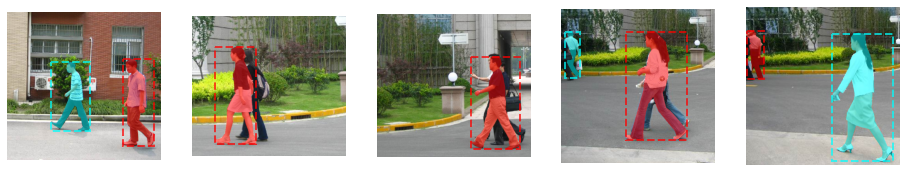

In [8]:
plot_with_mask(img_path, mask_path, ['000.png',
                                     '001.png',
                                     '002.png',
                                     '003.png',
                                     '004.png'])

In [9]:
def split_data(img_path, mask_path, train_path, test_path):
    img_names = list(os.walk(img_path))[0][2]
    img_names.sort()
    train_imgs_names = img_names[:int(len(img_names) / 5 * 4)]
    test_imgs_names = img_names[int(len(img_names) / 5 * 4):]
    train_img = train_path + '/imgs/'
    train_masks = train_path + '/masks/'
    test_img = test_path + '/imgs/'
    test_masks = test_path + '/masks/'
    os.system(f'mkdir -p {train_img}')
    os.system(f'mkdir -p {train_masks}')
    os.system(f'mkdir -p {test_img}')
    os.system(f'mkdir -p {test_masks}')
    for img_name in train_imgs_names:
        os.rename(img_path + img_name, train_img + img_name)
        os.rename(mask_path + img_name, train_masks + img_name)
    for img_name in test_imgs_names:
        os.rename(img_path + img_name, test_img + img_name)
        os.rename(mask_path + img_name, test_masks + img_name)

In [10]:
train_path = '/content/train'
test_path = '/content/test'

In [11]:
split_data(img_path, mask_path, train_path, test_path)

### **Задание 2** (4 балла)

Посмотрите что принимает на вход та Mask R-CNN, которую вы выбрали. Напишите для нее Dataset.

In [12]:
mrcnn = mask_rcnn(pretrained=True)

In [13]:
#Заготовка датасета, можете менять её как удобно, главное чтобы работало
class Pedestrian(object):
    def __init__(self, root, transforms, device, batch_size):
        self.transforms = transforms
        # у нас нет аннотации, список картинок и масок надо подтянуть из root
        self.names = list(os.walk(root + '/imgs'))[0][2]
        self.imgs_path = root + '/imgs/'
        self.masks_path = root + '/masks/'
        self.device = device
        self.batch_size = batch_size
        assert len(self.names) % batch_size == 0
    
    def get_image_name(self, idx):
        return self.imgs_path + self.names[idx]

    def __getitem__(self, idxs):
        # считываем картинку и маску с помощью PIL
        img_list = []
        targets_list = []
        for idx in range ((idxs - 1) * self.batch_size, idxs * self.batch_size):
            img = Image.open(self.imgs_path + self.names[idx])
            #код код теперь у нас есть картинки
            mask = cv2.imread(self.masks_path + self.names[idx])[:, :, 1]
            n = len(np.unique(mask))
            #код код теперь у нас есть маска

            masks = torch.zeros((n - 1, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
            boxes = torch.zeros((n - 1, 4), dtype=torch.float)
            for i in range(1, n):
                masks[i - 1, :, :] = torch.from_numpy(mask == i)
                boxes[i - 1] = torch.tensor(get_box(mask, i), dtype=torch.float)
            #код код получили маски отдельных объектов
            #используйте функцию для вычисления бокса по маске

            #хоть лейбл один, он всё же нужен для обучения (для каждого инстанса нужна 1)
            labels = torch.ones((n - 1), dtype=torch.int64)

            if self.transforms is not None:
                img = self.transforms(img)
            
            img_list.append(img.to(device))
            targets_list.append({'labels': labels.to(device),
                                'boxes': boxes.to(device),
                                'masks': masks.to(device)})
        
        #пример как может выглядеть выход, можете оформить все targets в словарь
        return img_list, targets_list

    def __len__(self):
        return int(len(self.names) / self.batch_size)

## Часть 2. Копаемся в Mask R-CNN

Это самая свободная в реализации часть - модифицируем и учим Mask R-CNN.

### **Задание 3**. (2 балла) 

Нужно взять Mask R-CNN и заменить у нее последний слои (помните, у нас всего 1 класс?)

### **Задание 4**. (12 баллов) 

1. Подотовьте код для обучения и тестирования. **Явно пропишите свои функции train, evaluate.**

Процедуры обучения и эвала можно посмотреть тут: [тык 1](https://github.com/pytorch/vision/blob/master/references/detection/engine.py), [тык 2](https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py#L1736), [тык 3](https://github.com/pytorch/vision/blob/0467c9d74c9b34f91df905ed8cf8433de48d7fa5/references/detection/coco_eval.py#L19). Во многих репозиториях вы увидите, что процедуры написаны специально для [coco](https://cocodataset.org/#home) - это потому что это самый популярный датасет для детектирования и сегментации. 

2. Постарайтесь выйти на хорошее качество на test - **bbox AP@IoU=0.75 >=0.95**. И напишите в комментариях какими источниками пользовались.

3. Получите также результат детекции/сегментации для класса 1 (person) у первоначальной сети (не измененной и доученной вами) на том же pedestrians test сете. Получилось ли у вас улучшить показатели для этой задачи по сравнению с базовой моделью? 

Ещё раз почитать про AP [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) или на русском то же самое [тут](https://ml.i-neti.com/ru/2019/07/05/russkiy-map-mean-average-precision-v-detektsii-obektov/).

Да, нужно будет много покопаться в коде, но **вы справитесь**.


***Не измененная сеть***

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
data = Pedestrian(test_path,
                  transforms.Compose([
                  transforms.ToTensor()
                  ]),
                  device,
                  batch_size=5)

In [16]:
def draw_rezults(model, data, idxs, min_score_class, min_score_mask):
    with torch.no_grad():
        _, ax = plt.subplots(1, len(idxs), figsize=(16, 10))
        for j, idx in enumerate(idxs):
            ax[j].axis('off')
            answer = model(data[idx][0][0].unsqueeze(0))[0]
            img = cv2.imread(data.get_image_name((idx - 1) * data.batch_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            boolidx = (answer['scores'] > min_score_class) * (answer['labels'] == 1)
            n = int((boolidx).sum())
            masks = (answer['masks'][boolidx] > min_score_mask).type(torch.int).cpu().numpy()[:, 0, :, :]
            boxes = (answer['boxes'][boolidx]).type(torch.int).cpu().numpy()
            colors = random_colors(n)
            for i in range(0, n):
                x1, y1, x2, y2 = boxes[i]
                p = patches.Rectangle((x1, y1),
                                      x2 - x1,
                                      y2 - y1,
                                      linewidth=2,
                                      alpha=0.7,
                                      linestyle="dashed",
                                      edgecolor=colors[i],
                                      facecolor='none')
                ax[j].add_patch(p)
                ax[j].imshow(apply_mask(img, masks[i], colors[i]))

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


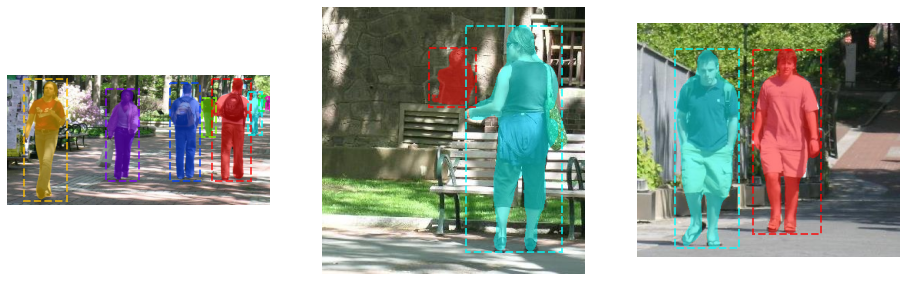

In [17]:
draw_rezults(mrcnn.eval().to(device), data, [0, 1, 2], 0.5, 0.5)

In [18]:
#считаем intersection для двух групп боксов
def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


#cчитаем IoU для двух групп боксов
def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    #площади всех боксов
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    return intersection / union  # (n1, n2)


In [19]:
def mAp(pred, true, min_IoU):
    n = true.size(0)
    mask = torch.zeros(pred.size(0), dtype=torch.float)
    IoUs = find_jaccard_overlap(pred, true)
    mask[IoUs.argmax(dim=0)] = 1
    mask = (mask * (IoUs.max(dim=1).values > min_IoU))
    mask = torch.cumsum(mask, dim=0)
    rec = mask / n
    pres = mask / torch.arange(start=1, end=mask.size(0) + 1)
    AP = torch.tensor(0, dtype=torch.float, device=device)
    num = 0
    for recall in torch.unique(rec):
         AP += torch.max(pres[rec == recall])
         num += 1
    return AP / num

In [20]:
def evaluate(model, data, min_IoU, min_score):
    AP = torch.tensor(0, dtype=torch.float, device=device)
    count = 0
    with torch.no_grad():
        for elem in tqdm(data):
            pred = model(elem[0])
            for j in range(len(pred)):
                true = elem[1][j]['boxes'].cpu()
                AP += mAp(pred[j]['boxes'][pred[j]['scores'] > min_score].cpu(), true, min_IoU)
                count += 1
    return AP / count

In [21]:
meanAP_not_trained = evaluate(mrcnn.eval().to(device), data, 0.75, 0.5)
print(' ')
print(f'mAP@IoU=75 = {meanAP_not_trained.item()} у не перетренированной сети')

7it [00:05,  1.18it/s]

 
mAP@IoU=75 = 0.9246598482131958 у не перетренированной сети


In [22]:
 torch.cuda.empty_cache()

***Изменяем последние слои***

In [23]:
class Custom_mask_rcnn(nn.Module):
    def __init__(self, device):
        super(Custom_mask_rcnn, self).__init__()
        self.model = mask_rcnn(pretrained=True)

        for param in self.model.backbone.parameters():
            param.requires_grad = False

        for param in self.model.roi_heads.parameters():
            param.requires_grad = False
        
        for param in self.model.rpn.parameters():
            param.requires_grad = False

        self.model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=2, bias=True)
        self.model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=8, bias=True)
        self.model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, 2,  kernel_size=(1, 1), stride=(1, 1))

        self.model.to(device)
        
    
    def forward(self, images, targets=None):

        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])

        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))
        
        if targets:
            self.model = self.model.train()
            imgs, targets = self.model.transform(images, targets=targets)
            x = self.model.backbone(imgs.tensors)
            proposals, _ = self.model.rpn(imgs, x, targets)
            _, detector_losses = self.model.roi_heads(x, proposals, imgs.image_sizes, targets)
            losses = {}
            losses.update(detector_losses)
            return losses
        else:
            with torch.no_grad():
                self.model = self.model.eval()
                answer = self.model(images)
                for elem in answer:
                    elem['scores'] = elem['scores'].cpu()
                    elem['boxes'] = elem['boxes'].cpu()
                    elem['labels'] = elem['labels'].cpu()
                    elem['masks'] = elem['masks'].cpu()
                    for ans in elem.values():
                        ans = ans.cpu()
            return answer

In [24]:
model = Custom_mask_rcnn(device)
data_test = Pedestrian(test_path,
                  transforms.Compose([
                  transforms.ToTensor()
                  ]),
                  device,
                  batch_size=5)

data_train = Pedestrian(train_path,
                  transforms.Compose([
                  transforms.ToTensor()
                  ]),
                  device,
                  batch_size=5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0008)

In [25]:
def train(model, data, num_epoch, optimizer):
    for epoch in range(num_epoch):
        epoch_loss = 0
        iter_count = 0
        for elem in tqdm(data, 
                         position=0,
                        leave=True,
                        mininterval=1):
            optimizer.zero_grad()

            dict_loss = model(elem[0], elem[1])
            loss = dict_loss['loss_box_reg'] + dict_loss['loss_classifier'] + dict_loss['loss_mask']

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            iter_count += 1
            
            
        print(f"{epoch} epoch ended, loss {epoch_loss / iter_count}")

In [26]:
train(model, data_train, 5, optimizer)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
25it [00:19,  1.29it/s]                        
  0%|          | 0/24 [00:00<?, ?it/s]

0 epoch ended, loss 0.8515696406364441


25it [00:19,  1.28it/s]                        
  0%|          | 0/24 [00:00<?, ?it/s]

1 epoch ended, loss 0.46697718858718873


25it [00:19,  1.26it/s]                        
  0%|          | 0/24 [00:00<?, ?it/s]

2 epoch ended, loss 0.3720037066936493


25it [00:20,  1.24it/s]                        
  0%|          | 0/24 [00:00<?, ?it/s]

3 epoch ended, loss 0.33055092573165895


25it [00:20,  1.21it/s]                        

4 epoch ended, loss 0.3066864389181137


In [27]:
meanAP_trained = evaluate(model, data_test, 0.75, 0.5)
print(f'mAP@IoU=75 = {meanAP_trained.item()} у перетренированной сети')

7it [00:05,  1.25it/s]

mAP@IoU=75 = 0.9952380657196045 у перетренированной сети


Скор почти стопроцентный, ура!

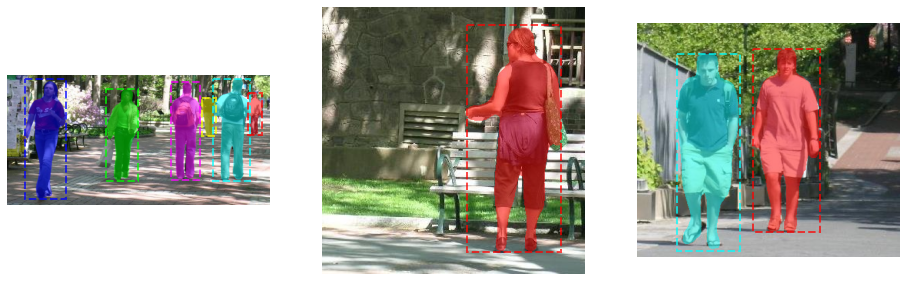

In [28]:
draw_rezults(model, data_test, [0, 1, 2], 0.5, 0.5)

## Часть 3. Копаемся с видео (это бонусная часть!)

Давайте теперь сделаем классный видос, чтобы все видели какие мы молодцы. 
Видео для теста живет тут: https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/

Берем оттуда **Campus sequences - [Seq.1, cam. 1].**

In [29]:
!wget https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c1.avi

--2020-10-30 09:52:15--  https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c1.avi
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40823766 (39M) [application/octet-stream]
Saving to: ‘campus4-c1.avi.1’

campus4-c1.avi.1    100%[===================>]  38.93M   612KB/s    in 50s     

2020-10-30 09:53:06 (792 KB/s) - ‘campus4-c1.avi.1’ saved [40823766/40823766]



### **Задание 5**. (6 баллов)

Пишем Dataset для видео. Впервые он будет иметь метод не get_item, а iter, так как по видео мы хотим пройти один раз и фрейм за фреймом отправлять в сетку, смотрите доки по IterableDataset [тут](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset). Можно использовать и обычный Dataset, но для get_item нам надо уметь выдергивать из видео фрейм по конкретному индексу, а для VideoCapture этот метод работает плохо (возможны неточные выдергивания и ваши визуализации полетят к чертям).

Так как это eval процедура, можете вообще не использовать Dataset и Dataloader, а читать последовательно кадры и оборачивать их в тензоры для сети. 

Далее прогоняем картинки через сетку и для кадров собираем результаты по маскам и детекциям (используйте в лоадере batch_size=1, num_workers=0 - иначе с VideoCapture могут возникнуть проблемы)

Пробегаем по видео ещё раз, рисуем на фреймах маски и боксы как и в 1 задании (цвет выберите один раз для всех масок чтобы каждый кадр он не мигал), собираем всё в видео - наслаждаемся. Видео сдайте вместе с заданием.


In [64]:
from google.colab.patches import cv2_imshow

In [30]:
# заготовка (можете не использовать, а написать по-своему)
class VideoSet(torch.utils.data.IterableDataset):
    """Dataset based on video file"""
    def __init__(self, video_path, transform, device):
        self.cap = cv2.VideoCapture(video_path)
        self.transform = transform
        self.device = device

    def __iter__(self):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #поставили указатель начала чтения на самое начало
        frame_id = 0 

        while True:
            status, image = self.cap.read()

            if image is None:
                raise StopIteration

            #тут допишите необходимые преобразования с image
            transformed_image = self.transform(image).to(self.device)

            yield (frame_id, transformed_image, image)

            #а ещё frame_id надо менять если id нуже
            frame_id += 1

In [31]:
video_path = '/content/campus4-c1.avi'

In [32]:
#прогоните каждый фрейм через сеть, получите и соберите где то все предсказания и
data_video = VideoSet(video_path,
                      transforms.Compose([
                      transforms.ToTensor()
                            ]),
                      device )

In [33]:
video_dict = {}
for elem in tqdm(data_video,
                 position=0,
                        leave=True,
                        mininterval=1):
    video_dict[elem[0]] = model([elem[1]])

1801it [03:29,  8.61it/s]


In [90]:
def process_video(cap, video_dict, min_score, min_mask):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('output.avi', fourcc, 25, (360, 288), isColor=True)
    color = random_colors(1)
    frame_id = 0
    while True:
        ret, img = cap.read()
    
        if ret == False:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        pred = video_dict[frame_id][0]
        instances = pred['scores'] > min_score
        for mask, box in zip(pred['masks'][instances], pred['boxes'][instances]):
            img = apply_mask(img, mask.numpy()[0] > min_mask, color[0])
            x1, y1, x2, y2 = box.numpy().astype(int)
            img = img.astype('uint8')
            cv2.rectangle(img, (x1, y1), (x2, y2), color[0], 1)
        #В колабе не очень с воспроизведением видео так что лучше посмотреть сохраненное
        #cv2_imshow(img)
        #clear_output(wait=True)
        frame_id += 1
        out.write(img)
    out.release()

In [91]:
cap = cv2.VideoCapture(video_path)
process_video(cap, video_dict, 0.5, 0.5)
cap.release()
cv2.destroyAllWindows()

### **Задание 6**. (4 балла)

Вспоминаем, что вообще то мы делали instance segmentaion и знаем, что у нас ходят отдельные люди - сделайте простенький трекинг с матчингом боксов с соседних фреймов по IoU детекций.

Идея проста - если на фреймах N и N+1 IoU двух боксов > threshold, то считаем что трек остался тот же - и для него сохраняем цвет визуализации бокса с фрейма N, если нет - заводим новый цвет. И учитываем что бокс может сматчиться только с ОДНИМ боксом с предыдущего кадра. Что за IoU ещё раз смотрим [тут](https://medium.com/towards-artificial-intelligence/understanding-iou-metric-in-object-detection-1e5532f06a76).

Для тех же боксов и масок нарисуйте ещё одно видео - где каждый человек будет иметь **один** цвет **от начала до конца** своего присутствия в видео (фактически трекаться). 

Этот прекрасный видос тоже прикладывайте к заданию, я обязательно посмотрю.

In [127]:
def match(curr, prev, min_IoU):
    challengers = find_jaccard_overlap(curr, prev).max(dim=1)
    return (challengers.values > min_IoU).numpy(), challengers.indices[challengers.values > min_IoU].numpy()

In [142]:
def track_video(cap, video_dict, min_score, min_mask, min_IoU, num_colors=7):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter('output_track.avi', fourcc, 25, (360, 288), isColor=True)

    color = random_colors(num_colors)
    frame_id = 1

    ret, img = cap.read()
    if ret == False:
        return 

    pred = video_dict[0][0]
    instances = pred['scores'] > min_score

    prev_boxes = pred['boxes'][instances]
    prev_colors = np.arange(len(prev_boxes))

    i = 0
    for mask, box in zip(pred['masks'][instances], prev_boxes):
        img = apply_mask(img, mask.numpy()[0] > min_mask, color[prev_colors[i]])
        x1, y1, x2, y2 = box.numpy().astype(int)
        img = img.astype('uint8')
        cv2.rectangle(img, (x1, y1), (x2, y2), color[prev_colors[i]], 1)
        i += 1
    

    while True:
        ret, img = cap.read()
    
        if ret == False:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pred = video_dict[frame_id][0]
        instances = pred['scores'] > min_score

        new_boxes = pred['boxes'][instances]
        new_colors = np.arange(len(new_boxes))
        if len(prev_boxes) > 0 and len(new_boxes) > 0:
            matches_mask, matches_ind = match(new_boxes, prev_boxes, min_IoU)
            new_colors[matches_mask] = prev_colors[matches_ind]
        i = 0
        for mask, box in zip(pred['masks'][instances], new_boxes):
            img = apply_mask(img, mask.numpy()[0] > min_mask, color[new_colors[i]])
            x1, y1, x2, y2 = box.numpy().astype(int)
            img = img.astype('uint8')
            cv2.rectangle(img, (x1, y1), (x2, y2), color[new_colors[i]], 1)
            i += 1

        frame_id += 1
        prev_boxes = new_boxes
        prev_colors = new_colors
        out.write(img)
    out.release()

In [143]:
cap = cv2.VideoCapture(video_path)
track_video(cap, video_dict, 0.5, 0.5, 0.6)
cap.release()
cv2.destroyAllWindows()

## **А вот и конец дз. Вы просто великолепны!**